#### 모델 : 생선 품종 분류 모델
- 데이터 : fish.csv (2가지 품종의 생선 데이터)
- 피  쳐 : Weight, Length
- 타  겟 : Species
- 학습유형: 지도학습 + 분류 (도미, 빙어 분류는 이진 분류)

(1) 모듈 로딩 & 데이터 준비

In [469]:
import pandas as pd                                     #데이터 파일 관련 모듈
from sklearn.neighbors import KNeighborsClassifier      #기계학습 관련 모듈

In [470]:
data_file = '../data/fish.csv'

In [471]:
# 5개 피쳐/특성 중 2개의 피쳐/특성 선택
fishDF = pd.read_csv(data_file, usecols = [0,1,2])
fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length   159 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.9+ KB


In [472]:
# Bream, Smelt 품종 행만 추출
mask = fishDF.Species.isin(['Bream', 'Smelt']) #Boolean Indexing

#해당 행만 도출
twoFishDF = fishDF[mask]
twoFishDF.index

# 인덱스 정리
twoFishDF.reset_index(drop=True,inplace =True)
twoFishDF

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5
3,Bream,363.0,29.0
4,Bream,430.0,29.0
5,Bream,450.0,29.7
6,Bream,500.0,29.7
7,Bream,390.0,30.0
8,Bream,450.0,30.0
9,Bream,500.0,30.7


In [473]:
# Bream, Smelt 품종명을 수치화
#twoFishDF.Species.replace({'Bream':0, 'Smelt':1}, inplace = True)

twoFishDF.loc[:,'Species'] = twoFishDF['Species'].replace({'Bream':0, 'Smelt':1}).copy()      
# 이르케하면 경고가 안뜬다. 다만, object로 되어있기 때문에 int로 바꾸어 주어야 한다.
#twoFishDF.head()
twoFishDF.dtypes

Species     object
Weight     float64
Length     float64
dtype: object

In [474]:
twoFishDF['Species'] = twoFishDF['Species'].astype('int64')
twoFishDF.dtypes

C:\Users\kdp\AppData\Local\Temp\ipykernel_12032\4197498798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoFishDF['Species'] = twoFishDF['Species'].astype('int64')


Species      int64
Weight     float64
Length     float64
dtype: object

(2) 데이터 전처리

In [475]:
# Weight, Length로 품종 구별이 가능한지 시각화

twoFishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  49 non-null     int64  
 1   Weight   49 non-null     float64
 2   Length   49 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.3 KB


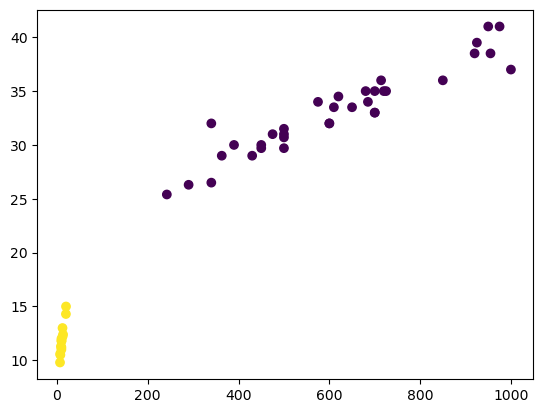

In [476]:
Weight_data = twoFishDF.Weight
Length_data = twoFishDF.Length

import matplotlib.pyplot as plt

plt.scatter(Weight_data, Length_data, c = twoFishDF.Species)
plt.show()

(3) 기계학습을 위한 데이터 준비
- 피쳐/특성 + 타겟/라벨/클래스
- 학습용 데이터셋  : 80%
- 테스트용 데이터셋 : 20%

(+) 꼭 8:2 할 필요 없다. .75:.25도 해도 되고 암튼 그럼

(3-1) 직접 타겟/라벨 컬럼의 비율을 고려해서 학습 & 테스트용 데이터셋 준비

In [477]:
# 데이터 섞기 => 100% 모두 섞기
# 만약 섞지 않는다면 학습은 브림 위주, 테스트는 다른 종 위주여서 의미가 없음. 그래서 데이터를 섞고 나누어주어야 한다.
twoFishDF = twoFishDF.sample(frac = 1.)
#만약 frac 파라미터 값을 .5로 줬다면 반틈만 섞인다.
print(twoFishDF.shape)

# ======> 하지만 원본 데이터가 bream과 smelt가 개수가 같지않으므로 한쪽으로 편향 될 가능성이 크다.

(49, 3)


In [478]:
# 학습과 테스트 비율 조절 개수를 계산
num = round(twoFishDF.shape[0] * 0.8)

# 학습 데이터셋 추출
trainDF = twoFishDF.iloc[:num+1]
print(f"trainDF.shape: {trainDF.shape}")

# 테스트 데이터셋 추출
testDF = twoFishDF.iloc[num:]
print(f"testDF.shape: {testDF.shape}")

trainDF.shape: (40, 3)
testDF.shape: (10, 3)


(3-2) scikit-learn 모듈 활용한 학습&테스트용 데이터셋 준비
- 추가 모듈 로딩

In [479]:
from sklearn.model_selection import train_test_split

In [480]:
# 특성과 타겟 분리
featureDF = twoFishDF[twoFishDF.columns[1:]]
targetSR = twoFishDF.Species

print(f"featureDF => {featureDF.shape} \n {featureDF.head(2)}")
print(f"targetSR => {targetSR.shape} \n {targetSR.head(2)}")

featureDF => (49, 2) 
     Weight  Length
37     7.0    10.6
12   500.0    31.5
targetSR => (49,) 
 37    1
12    0
Name: Species, dtype: int64


In [481]:
## -- 비율 설정 없이 학습/테스트 셋 분리
## -- [전달] 피쳐 데이터, 타겟 데이터
## -- [기본] shuffle = True, train: test = 0.75:0.25
## -- [반환] 학습용 피쳐, 태스트용 피쳐, 학습용 타겟, 테스트용 타겟
X_train, X_test, y_train, y_test = train_test_split(featureDF,targetSR)

In [482]:
print(f"X_train : {X_train.shape}")
print(X_train.head(2))
print()
print(f"y_train : {y_train.shape}")
print(y_train.head(2))
print()
print(f"X_test : {X_test.shape}")
print(X_test.head(2))
print()
print(f"y_test : {y_test.shape}")
print(y_test.head(2))

X_train : (36, 2)
    Weight  Length
24   700.0    35.0
15   600.0    32.0

y_train : (36,)
24    0
15    0
Name: Species, dtype: int64

X_test : (13, 2)
    Weight  Length
43     9.8    12.0
41    10.0    11.8

y_test : (13,)
43    1
41    1
Name: Species, dtype: int64


In [483]:
# 타겟/클래스 비율
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

Species
0    0.75
1    0.25
Name: count, dtype: float64
Species
0    0.615385
1    0.384615
Name: count, dtype: float64


In [484]:
## -- 비율 설정과 함께 학습/테스트 셋 분리 - 1
## -- [전달] 피쳐 데이터, 타겟 데이터
## -- [기본] shuffle = True
## -- [설정] train:test = 0.9:0.1 => test_size, train_size 매개변수 값 설정
## -- [반환] 학습용 피쳐, 태스트용 피쳐, 학습용 타겟, 테스트용 타겟
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.1)

#test_size 나 train_size 중 1개의 값을 정해주면 거기서 뺀 거를 다른 거의 사이즈로 자동 설정됨
#근데 이렇게 해도 종 종류별로 그 비율을 맞춰주지는 않는다는 문제점이 발생

In [485]:
print(f"X_train : {X_train.shape}")
print(X_train.head(2))
print()
print(f"y_train : {y_train.shape}")
print(y_train.head(2))
print()
print(f"X_test : {X_test.shape}")
print(X_test.head(2))
print()
print(f"y_test : {y_test.shape}")
print(y_test.head(2))

X_train : (44, 2)
    Weight  Length
11   500.0    31.0
5    450.0    29.7

y_train : (44,)
11    0
5     0
Name: Species, dtype: int64

X_test : (5, 2)
    Weight  Length
30   920.0    38.5
18   610.0    33.5

y_test : (5,)
30    0
18    0
Name: Species, dtype: int64


In [486]:
## -- 비율 설정과 함께 학습/테스트 셋 분리 - 2
## -- [전달] 피쳐 데이터, 타겟 데이터
## -- [기본] shuffle = True
## -- [설정] train:test = 0.9:0.1 => test_size, train_size 매개변수 값 설정
## --       분류의 경우 target이 불균형일 경우 비율 지정하는 stratify 매개변수를 target으로 설정
## -- [반환] 학습용 피쳐, 태스트용 피쳐, 학습용 타겟, 테스트용 타겟
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.1, stratify = targetSR)

In [487]:
print(f"X_train : {X_train.shape}")
print(X_train.head(2))
print()
print(f"y_train : {y_train.shape}")
print(y_train.head(2))
print()
print(f"X_test : {X_test.shape}")
print(X_test.head(2))
print()
print(f"y_test : {y_test.shape}")
print(y_test.head(2))

X_train : (44, 2)
    Weight  Length
43     9.8    12.0
35     6.7     9.8

y_train : (44,)
43    1
35    1
Name: Species, dtype: int64

X_test : (5, 2)
    Weight  Length
2    340.0    26.5
15   600.0    32.0

y_test : (5,)
2     0
15    0
Name: Species, dtype: int64


In [488]:
# 타겟/클래스 비율
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

Species
0    0.704545
1    0.295455
Name: count, dtype: float64
Species
0    0.8
1    0.2
Name: count, dtype: float64


In [489]:
### 검증용 데이터셋 준비 ==> 학습용 데이터셋에서 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, stratify=y_train)

In [490]:
print(f"X_train : {X_train.shape}")
print(X_train.head(2))
print()
print(f"y_train : {y_train.shape}")
print(y_train.head(2))
print()
print(f"X_val : {X_val.shape}")
print(X_test.head(2))
print()
print(f"y_val : {y_val.shape}")
print(y_test.head(2))

X_train : (39, 2)
    Weight  Length
27   714.0    36.0
13   340.0    32.0

y_train : (39,)
27    0
13    0
Name: Species, dtype: int64

X_val : (5, 2)
    Weight  Length
2    340.0    26.5
15   600.0    32.0

y_val : (5,)
2     0
15    0
Name: Species, dtype: int64


(4) 학습 진행
- 학습 방법 : 지도학습 / 분류 => KNN
- 모델 인스턴스 생성 => fit( ) 메서드

In [491]:
# 모델 인스턴스 생성
model = KNeighborsClassifier()
model

KNeighborsClassifier()

In [492]:
# 학습 진행 => 학습용 데이터로 진행
model.fit(X_train, y_train)

KNeighborsClassifier()

(5) 테스트 진행 => 학습에 사용되지 않은 데이터로 진행

In [493]:
model.score(X_val, y_val)
#지금은 뭘해도 100이 나올것 , 데이터 크기가 작아서 ~!

1.0

(6) 모델 활용 예측 => 새로운 데이터로 진행

In [494]:
# 학습 데이터에서 쪼개진 데이터라 완전히 NEW 데이터가 아니다
model.predict(X_test)

array([0, 0, 0, 1, 0], dtype=int64)

In [495]:
y_test
#위에서 예측한것과 일치하는가? 결과를 보니 위의 반환값과 일치한다.

2     0
15    0
14    0
46    1
18    0
Name: Species, dtype: int64

(6-2) 사용자로부터 전달받은 새로운 데이터에 대한 예측
==> 학습할 때 전달되는 피쳐 형태와 동일한 형태의 데이터이어야 한다.

In [496]:
## 길이 25, 무게 160인 생선의 품종 예측 -----------------------
new_data = pd.DataFrame([[160,25]], columns = twoFishDF.columns[1:])
new_data

,Weight,Length
0,160,25


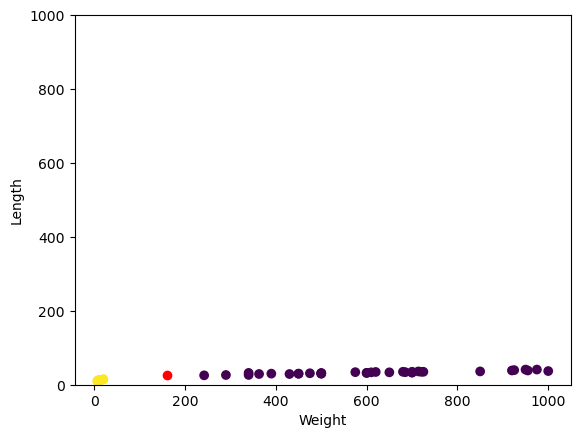

In [521]:
# 새로운 데이터 시각화
plt.plot(new_data.Weight, new_data.Length, 'ro')

# 학습 데이터 시각화
plt.scatter(twoFishDF.Weight, twoFishDF.Length, c = twoFishDF.Species)
plt.xlabel('Weight')
plt.ylabel('Length')
plt.ylim((0,1000))
plt.show()

In [505]:
# 생성된 모델로 새로운 데이터 품종 예측
model.predict(new_data)

array([1], dtype=int64)

In [514]:
# 새로운 데이터의 최근접 데이터 추출
_, index = model.kneighbors(new_data)   #첫번째 반환값은 필요없고 2번째 반환값만 사용하고 싶다고 표현한것이다.
index

array([[ 4, 34, 15, 18, 21]], dtype=int64)

In [515]:
index.tolist()[0]

[4, 34, 15, 18, 21]

In [517]:
result = twoFishDF.iloc[index.tolist()[0]]
result

,Species,Weight,Length
43,1,9.8,12.0
42,1,9.9,11.8
28,0,850.0,36.0
17,0,700.0,33.0
13,0,340.0,32.0
